# Strategies for Robust Covariance Matrix Estimation in Portfolio Management

In [1]:
# Standard libraries for data handling and numerical operations
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations

# Libraries for plotting and visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Import the font manager from matplotlib for managing fonts
import matplotlib.font_manager as font_manager

import seaborn as sns  # For advanced visualization styles

# Additional libraries for statistical analysis and optimization
import scipy.stats  # For statistical functions
from scipy.optimize import minimize  # For optimization functions

# Libraries for fetching financial data and handling date/time
import yfinance as yf  # For fetching financial data using yfinance
from pandas_datareader import data  # For fetching financial data
from datetime import datetime  # For handling date and time objects

# Import tabulate for creating tables
from tabulate import tabulate

# Custom toolkit for portfolio optimization
import sys
sys.path.append("../../")  # Adding the toolkit's directory to system path
import PortfolioOptimizationKit as pok  # Custom toolkit for portfolio optimization

# Setting the plot style for visual consistency
sns.set_style("dark")  # Setting the plot style for Seaborn

In [2]:
# This line loads the autoreload extension in Jupyter.
# Autoreload helps automatically reload imported modules before executing code,
# ensuring that changes in the modules are reflected without restarting the kernel.
%load_ext autoreload

# This line configures the autoreload extension to reload all modules (not just those listed in %aimport)
# every time code is executed. '2' is the mode of autoreload that ensures this behavior.
%autoreload 2

# This line sets up the Jupyter notebook to display matplotlib plots inline.
# This means that generated plots will appear directly below the code cell that produced them.
%matplotlib inline

In [3]:
# Define the relative paths to the font files from the current working directory
montserrat_font_path = "../../toolbox/font/Montserrat-ExtraBold.ttf"
paytone_font_path = "../../toolbox/font/PaytoneOne.ttf"
sourcesanspro_font_path = "../../toolbox/font/SourceSansProSemiBold.ttf"

# Set the Montserrat-ExtraBold font properties
montserrat_font = font_manager.FontProperties(fname=montserrat_font_path, size=12)

# Set the PaytoneOne font properties
paytone_font = font_manager.FontProperties(fname=paytone_font_path, size=11)

# Set the SourceSansPro font properties
sourcesanspro_font = font_manager.FontProperties(fname=sourcesanspro_font_path, size=10)

## Estimates for the Covariance Matrix

The inception of **`Modern Portfolio Theory (MPT) `** is attributed to **`Markowitz's efficient frontier analysis in 1952`**. Early implementations, however, were limited due to naive input parameter estimations, often leading to impractical portfolio allocations.

**`1.2-Essentials of Portfolio Optimization`** of the first course extensively covered MPT, particularly constructing efficient frontiers with historical data to identify optimal weight allocations in a portfolio of $N$ stocks. These allocations were based on past returns, covariances, and variances. The challenge arises in real-time portfolio construction, as future returns and covariances are unknown and must be estimated.

This discussion aims to bridge the gap between theory and practice in portfolio construction, emphasizing on generating enhanced parameter estimates to improve portfolio optimization outputs, particularly focusing on risk parameter estimates. It delves into addressing sample risk and enhancing covariance matrix estimation through factor and/or Bayesian techniques and statistical shrinkage estimators.

### The Curse of Dimensionality

For constructing a portfolio of $N$ stocks, the estimations needed are:

- $N$ expected returns,
- $N$ volatilities, and
- $N(N-1)/2$ covariances

The covariance matrix, with $N$ entries minus the diagonal of $N$ variances and considering its symmetric nature, leads to a significant number of parameters for large $N$. For instance, a portfolio with 500 stocks would require estimating 125,250 entries, $N + N(N-1)/2 = N(N+1)/2 = 125,250$.

Large portfolios often have more parameters to estimate than the available sample size (e.g., length of time series data). **`While increasing sample size could improve accuracy, it may introduce modeling bias`**. Therefore, reducing the number of parameters is usually preferred.

### Revisiting Parameter Estimations in Portfolio Theory

#### Covariance Matrix Definition

Let $\Sigma$ represent the $N\times N$ symmetric square covariance matrix, with elements $c_{ij} := \rho_{ij} \sigma_i \sigma_j$ ($i,j=1,\dots,N$) denoting the **covariance** between assets $i$ and $j$, where $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ are the volatilities and correlation coefficient of assets $i$ and $j$, respectively. For $i=j$, $c_{ii}=\sigma_i^2$ is the variance of asset $i$ (**diagonal entries are the variances**).
The portfolio's volatility is then $\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }$.

#### Estimating Covariances: Different Approaches

1. **Sample Covariance Matrix**:
   - **Approach**: Utilizes the sample covariance matrix $\Sigma = [c_{ij}]$.
   - **Characteristics**: This method carries no model risk, as it purely applies the definition. However, it depends on the sample size of the time series data. The number of parameters estimated is $N(N+1)/2$.

2. **Constant Correlation Model**:
   - **Approach**: Assumes a uniform correlation coefficient $\rho$ across all assets, simplifying the covariance matrix to $c_{ij} = \hat{\rho} \sigma_i \sigma_j$.
   - **Characteristics**: This method reduces the number of parameters to $N + 1$, from $N(N+1)/2$. It introduces model risk as it assumes a constant correlation, which might not be realistic. The constant $\hat{\rho}$ is calculated as the average of the actual correlations, $\hat{\rho} = \frac{1}{N(N-1)} \sum_{i \neq j}^N \rho_{ij}$.

3. **Factor Model Approach**:
   - **Approach**: Uses models like Sharpe's single-factor market model, where an asset's return over the risk-free rate is expressed as a function of market factors.
   - **Characteristics**: Multi-factor models can reduce the number of parameters significantly. For instance, a two-factor model with uncorrelated factors and errors can reduce the parameters to $2(N+1)$. This approach introduces model risk but can provide a more manageable number of risk parameters.

#### Statistical Shrinkage Method

- **Concept**: This method combines two covariance matrix estimates: one with high sample risk and another with high model risk.
- **Formula**: $E_{shrink} = \delta \hat{F} + (1-\delta)\hat{S}$, where $\hat{F}$ is the factor-model based estimator, $\hat{S}$ is a non-factor-model based estimator, and $\delta$ is the shrinkage factor between 0 and 1.

**Example Calculation**: For two stocks with volatilities of 20% and 30% and a sample correlation of 0.75, the covariance estimates are as follows:

- **Sample-Based Estimate**: $\text{Cov}(r_1, r_2) = \rho_{12} \sigma_1 \sigma_2 = 0.75 \times 0.2 \times 0.3 = 0.045$.
- **Constant Correlation Estimate**: With an average correlation $\rho_c = 0.54, $\text{Cov}(r_1, r_2) = \rho_c \sigma_1 \sigma_2 = 0.5 \times 0.2 \times 0.3 = 0.03$.
- **Statistical Shrinkage Estimate**: With $\delta = 0.5$, the estimate is $0.5 \times 0.045 + 0.5 \times 0.03 = 0.0375$.

### Analyzing Time-Varying Risk Parameters

The first observation in risk analysis is the non-constant nature of volatility over time. Estimating volatility should therefore consider its time variability.

For instance, examining total index market returns:

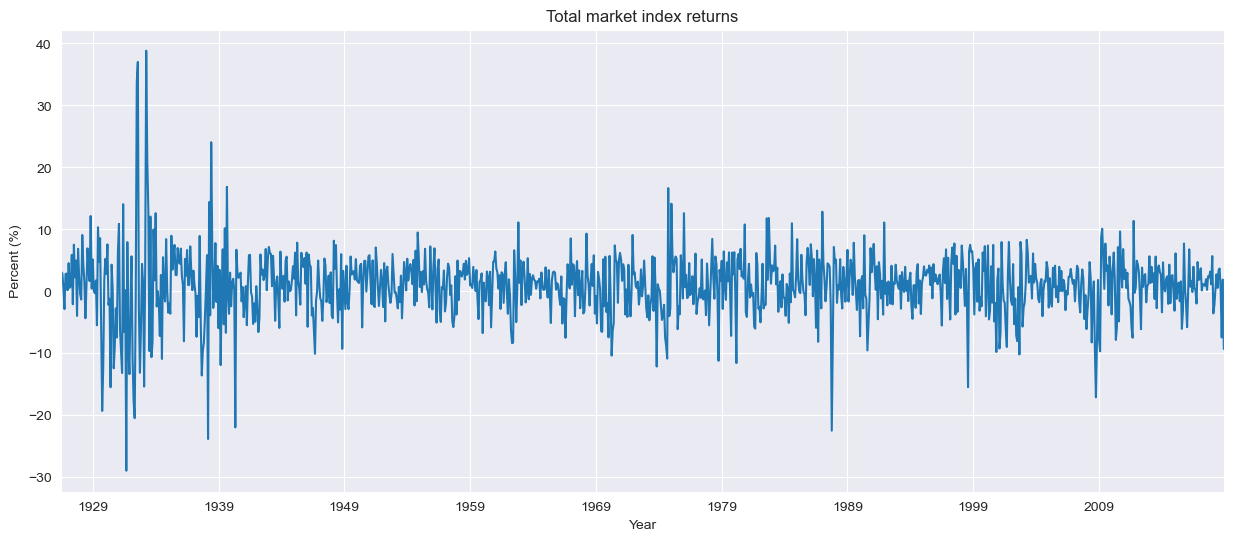

In [4]:
tot_mkt_rets = pok.get_total_market_index_returns()

# Create a plot for total market index returns
fig, ax = plt.subplots(1,1, figsize=(15,6)) 
(tot_mkt_rets * 100).plot(ax=ax, grid=True, title="Total market index returns")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("Year")
plt.show()

The code above retrieves total market index returns and plots them. It's important to scale the returns by 100 to convert them to percentages.

Next, the annualized volatility over the entire period is computed:

In [5]:
# Calculate annualized volatility over the entire period
ann_vol_constant = pok.annualize_vol(tot_mkt_rets, periods_per_year=12)
ann_vol_constant

0.18360776591130698

This code annualizes the volatility of the total market returns on a monthly basis (12 periods per year).

Then, a rolling window approach is used to compute the time series of annualized volatilities:

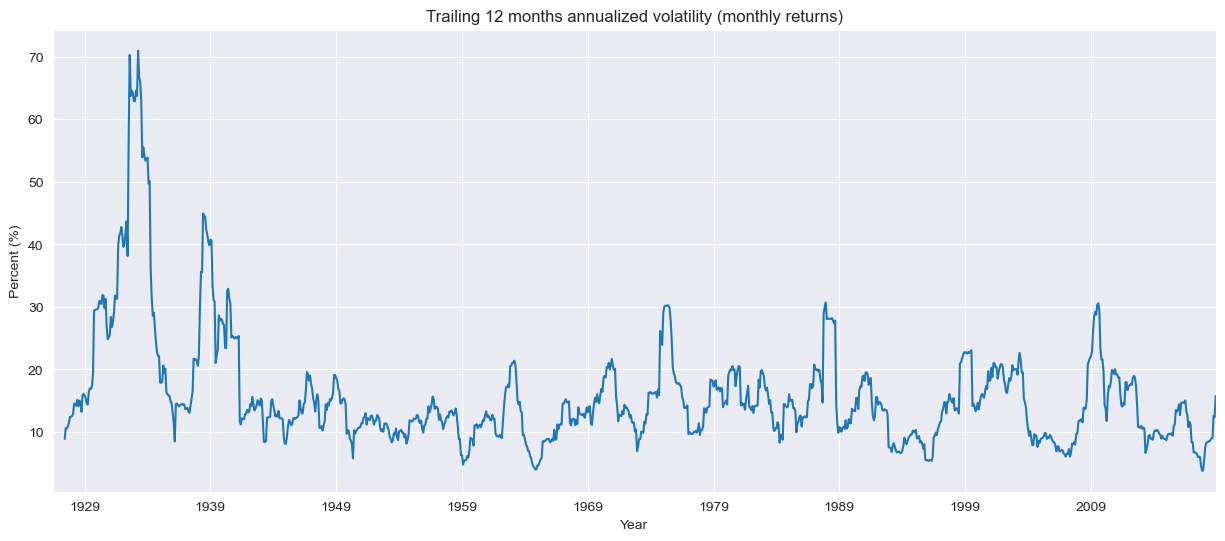

In [6]:
# Define the window size for rolling calculation (12 months)
window = 12
# Calculate rolling annualized volatility
ann_vol_tv = tot_mkt_rets.rolling(window = window).std() * np.sqrt(window)

# Plotting the rolling annualized volatility
fig, ax = plt.subplots(1,1, figsize=(15,6)) 
(ann_vol_tv * 100).plot(ax=ax, grid=True, title="Trailing 12 months annualized volatility (monthly returns)")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("Year")
plt.show()

This block calculates the rolling annualized volatility using a 12-month window and plots it.

The mean volatility of this time-varying series is given by:

In [7]:
# Compute the mean of the time-varying annualized volatility
ann_vol_tv.mean()

0.1577073219460171

This line of code calculates the mean of the annualized volatility over the selected rolling window, offering a dynamic view of volatility.

Exploring a 5-year window:

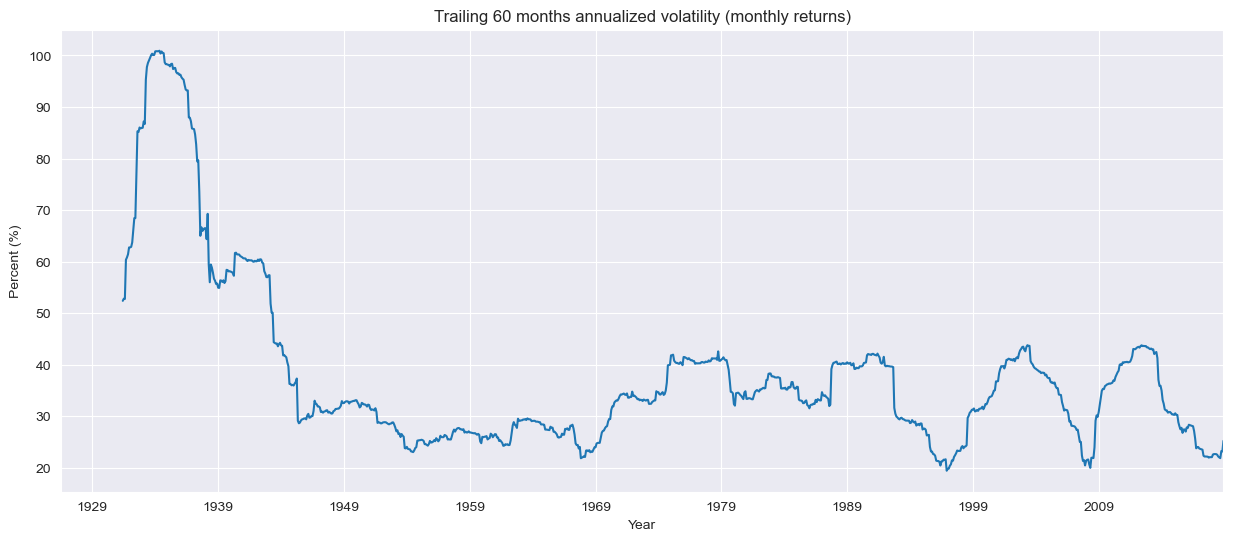

In [8]:
# Define a new window size for rolling calculation (60 months)
window = 60
# Calculate rolling annualized volatility for the 5-year window
ann_vol_tv = tot_mkt_rets.rolling(window = window).std() * np.sqrt(window)

# Plotting the rolling annualized volatility for the 5-year window
fig, ax = plt.subplots(1,1, figsize=(15,6)) 
(ann_vol_tv * 100).plot(ax=ax, grid=True, title="Trailing 60 months annualized volatility (monthly returns)")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("Year")
plt.show()

This segment repeats the rolling volatility calculation, this time using a 60-month window, to observe how extending the window affects the volatility estimates.

#### Constructing a Volatility Cone

A volatility cone can illustrate how volatility changes with different window sizes:

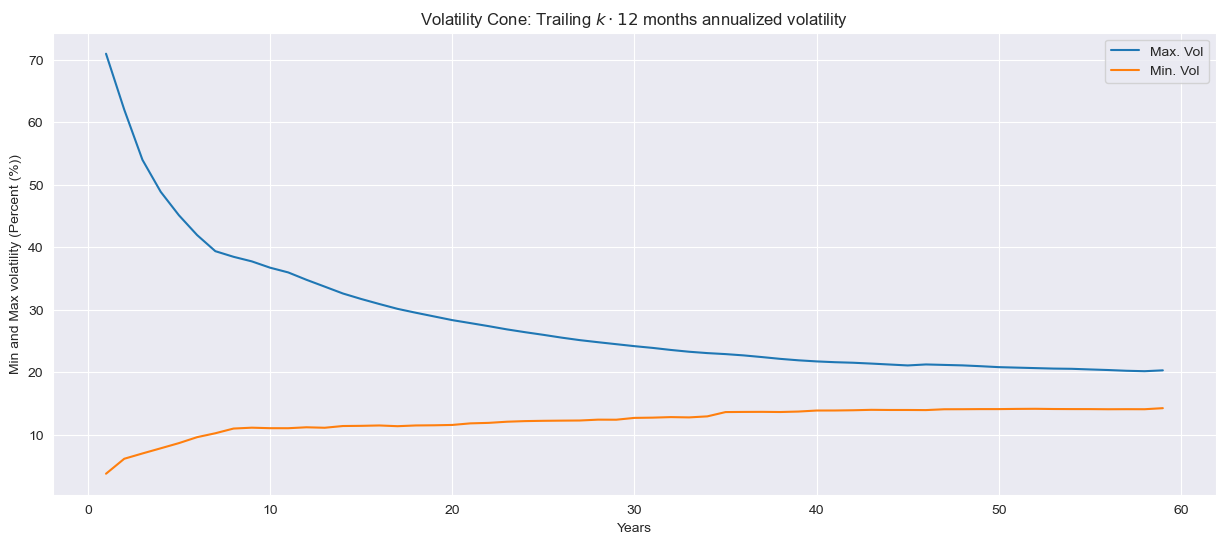

In [9]:
# Initialize parameters for constructing the volatility cone
window = 12
years  = np.arange(1,60,1)

# Calculate maximum and minimum volatilities for various window sizes
mm_vol = []
for k in years:
    ann_vol_tv = tot_mkt_rets.rolling(window = k * window).std() * np.sqrt(window)
    mm_vol.append([ann_vol_tv.max(), ann_vol_tv.min()])

# Creating a dataframe for the volatility cone
vol_cone = pd.DataFrame(mm_vol, index=years, columns=["Max. Vol", "Min. Vol"])

# Plotting the volatility cone
fig, ax = plt.subplots(1,1, figsize=(15,6)) 
(vol_cone * 100).plot(ax=ax, grid=True, title="Volatility Cone: Trailing $k\cdot12$ months annualized volatility")
ax.set_xlabel("Years")
ax.set_ylabel("Min and Max volatility (Percent (%))")
plt.show()

The above code calculates and plots the volatility cone, revealing how the maximum and minimum volatilities change as the window length increases. This visualization demonstrates that longer windows tend to reduce the observed maximum volatility, indicating the dynamic nature of market volatility.

The concept of uniform variance (homoskedasticity) is challenged by these observations. Markets often exhibit heteroskedastic behavior, where volatility is not constant and is influenced by prior variances, a phenomenon known as autoregression. Consequently, volatility estimation must account for these time variations.

#### Exponentially Weighted Moving Average (EWMA) in Volatility Estimation

**Defining Squared Error Returns**:

Squared error returns, denoted as $\epsilon_n^2$, are defined as $(\epsilon_n^2 := (r_n - \mu)^2$, where $\mu$ is the average return over the entire time series, $\mu:=\frac{1}{N}\sum_{n=1}^N r_n$.

- Traditional Variance Calculation

The variance, by definition, is the average of these squared error returns:

$$
\sigma^2_N = \frac{1}{N} \sum_{n=1}^N \epsilon_n^2 = \frac{1}{N}\epsilon_1^2 + \dots + \frac{1}{N}\epsilon_N^2,
$$

This can be interpreted as a weighted average where each weight is $\frac{1}{N}$ and $\sum_{n=1}^N \alpha_n = 1$. Thus, the variance can be represented as:

$$
\sigma^2_N = \sum_{n=1}^N \alpha_n \epsilon^2_n,
$$

where $\alpha_n = \frac{1}{N}$ for all $n$.

This conventional approach treats older returns equally with recent ones, which might not be optimal if return distributions are non-stationary and volatility changes over time.

#### Introducing EWMA

To address this, the EWMA model assigns more weight to recent observations and less to older ones. The weights in EWMA decline exponentially as we go back in time. They are defined as:

$$
\sigma^2_{N,EWA} = \sum_{n=1}^N \alpha_n \epsilon_n^2,
$$

where $\alpha_n = \frac{\lambda^{N-n}}{\sum_{n=1}^N \lambda^{N-n}}$ for all $n$, with $\lambda$ being the decay factor in the range $(0,1]$. The lower the decay factor, the more emphasis is placed on recent returns.

RiskMetrics, for example, commonly uses a decay factor of $\lambda=0.94$.

**Python Implementation**:

Python code to visualize weights in EWMA for different decay factors:

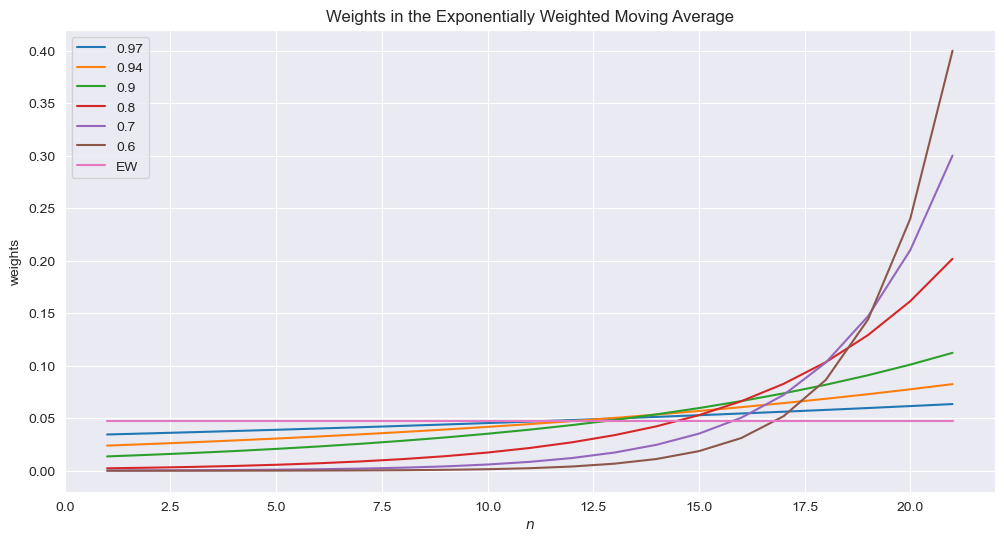

In [10]:
# Setting up parameters
N = 21
points = np.arange(1, N+1, 1)
decay_factor = [0.97, 0.94, 0.9, 0.8, 0.7, 0.6]

# Calculating weights for different decay factors
ww = []
for d in decay_factor:
    ww.append([d**(N-n) for n in points] / np.sum(d**(N-points)))

# Creating DataFrame to store weights
weigths = pd.DataFrame(ww, index=decay_factor).T
weigths["EW"] = 1/N
weigths.index = points

# Plotting the weights
fig, ax = plt.subplots(1,1, figsize=(12,6))
weigths.plot(ax=ax, grid=True, linestyle="-", title="Weights in the Exponentially Weighted Moving Average")
ax.set_ylabel("weights")
ax.set_xlabel("$n$")
ax.set_xlim([0, N+1])
plt.show()

#### Calculating EWMA Volatility

Comparing standard volatility to EWMA volatility:

In [11]:
# Obtaining total market index returns
tot_mkt_rets = pok.get_total_market_index_returns()
# Calculating standard annualized volatility
ann_vol_constant = pok.annualize_vol(tot_mkt_rets, periods_per_year=12, ddof=0)

# Displaying standard volatility
print("Standard volatility: {:.2f}%" .format(ann_vol_constant*100))

# Displaying EWMA volatility for different decay factors
print("Exponentially Weighted Moving Average:")
decays = [1, 0.97, 0.95, 0.93, 0.85, 0.7]
for d in decays:
    ann_vol_ewa = pok.annualize_vol_ewa(tot_mkt_rets, decay=d, periods_per_year=12)
    print("         decay = {:.2f}: {:.2f}%" .format(d, ann_vol_ewa*100))

Standard volatility: 18.35%
Exponentially Weighted Moving Average:
         decay = 1.00: 18.35%
         decay = 0.97: 12.58%
         decay = 0.95: 13.06%
         decay = 0.93: 14.03%
         decay = 0.85: 17.83%
         decay = 0.70: 22.80%


This code snippet computes and compares the standard volatility with the EWMA volatility for various decay factors. The EWMA volatility is expectedly different for each decay factor, with a factor of $1$ equating to standard volatility.

#### Understanding Auto-regressive Conditional Heteroscedasticity (ARCH) Model

The Auto-regressive Conditional Heteroscedasticity (ARCH) model extends the concept of time-varying variance, similar to the Exponentially Weighted Moving Average (EWMA) approach. In the ARCH model, variance at the current time is a function of a predetermined number of past squared error returns.

The ARCH model, denoted as ARCH($p$), is formulated as follows:

$$
\sigma_{N}^2 = \gamma V_L + \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2,
$$

where $V_L$ is the long-term variance estimate (like a 20-year or 50-year volatility estimate), and $\gamma$ plus the sum of $\alpha_n$'s equals 1. Here, $\omega = \gamma V_L$ is the weighted long-term variance estimate.

For instance, with $p=1$ (using only the last squared error return), the model simplifies to:

$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega}
+ \alpha_{N-1} \epsilon_{N-1}^2
\qquad\Longrightarrow\qquad
\sigma_{N}^2 = \omega + \alpha_{N-1} \epsilon_{N-1}^2,
$$

where $\gamma + \alpha_{N-1} = 1$.

#### Generalized Auto-regressive Conditional Heteroscedasticity (GARCH) Model

The Generalized Auto-regressive Conditional Heteroscedasticity (GARCH) model improves upon ARCH by incorporating a weighted average of past variances. A GARCH($p, q$) model includes both $p$ past squared error returns and $q$ past variances, defined as:

$$
\sigma_{N}^2 = \omega + \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2 + \sum_{m=1}^q \beta_{N-m} \sigma_{N-m}^2,
$$

where the sum of $\gamma$, $\alpha_{N-n}$'s, and $\beta_{N-m}$'s equals 1.

In the simplest GARCH(1,1) model, the formula becomes:

$$
\sigma_{N}^2 = \gamma V_L + \alpha_{N-1} \epsilon_{N-1}^2 + \beta_{N-1} \sigma^2_{N-1},
$$

with $\gamma + \alpha_{N-1} + \beta_{N-1} = 1$.

#### Increased Parameter Estimation in GARCH/ARCH Models

These models introduce additional parameters to estimate, especially for large asset portfolios. For instance, estimating volatility for each asset requires approximately $p+q$ parameters in a GARCH model. This can become complex when dealing with numerous assets and time-varying volatility.

#### Factor GARCH Approach

To manage this complexity, the Factor GARCH approach is used. Instead of using $q$ past variances in the GARCH($p,q$) model, it employs $K$ variances (with $K < q$) calculated using a $K$-factor model. This method is more efficient, particularly for portfolios with a significant number of assets, where it's crucial to account for time-varying volatility.

### Portfolio Index Construction with Different Covariance Estimators

#### Overview of Portfolio Types

**`Cap-weighted (CW)`** and **`equally-weighted (EW)`** portfolios are common in industrial implementations. CW portfolios are industry standards due to their low cost and turnover. They are often the default choice for many investors. However, they have some disadvantages, suggesting room for improvement.

EW portfolios are a straightforward alternative, requiring no covariance or expected returns estimation. They have been backtested and shown to be easy to build. The focus now shifts to constructing portfolios using different covariance estimators.

#### Python Implementation for Portfolio Construction

- Setting up Data and Backtesting CW and EW Portfolios

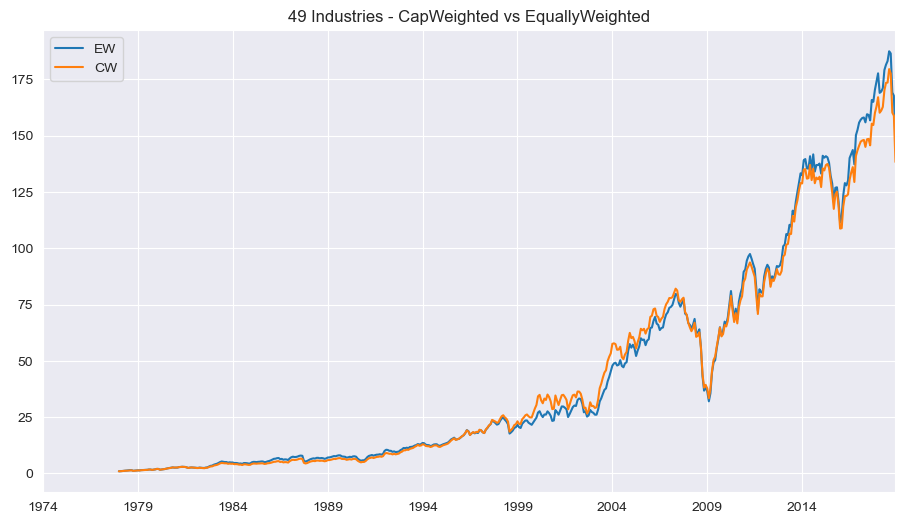

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.129403,0.189212,0.511098,-0.609188,6.670753,0.124043,0.083067,-0.598060
CW,0.127760,0.187210,0.508023,-0.582342,5.799216,0.121187,0.082793,-0.592711


In [12]:
nind = 49
ind_rets = pok.get_ind_file(filetype="rets", nind=nind, ew=True)["1974":]
ind_mcap = pok.get_ind_market_caps(nind=nind, weights=True)["1974":]

window = 4*12 
ew_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_ew)
cw_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_cw, cap_ws=ind_mcap)

bt_rets = pd.DataFrame({"EW": ew_rets, "CW": cw_rets})
bt_growth = (1 + bt_rets).cumprod()
bt_growth.plot(grid=True, figsize=(11,6), title="{} Industries - CapWeighted vs EquallyWeighted".format(nind))
plt.show()

pok.summary_stats(bt_rets.dropna())

This code retrieves industry returns and market caps, then backtests both CW and EW portfolios using a rolling window approach.

- Building Minimum Variance Portfolios with Different Covariance Estimators

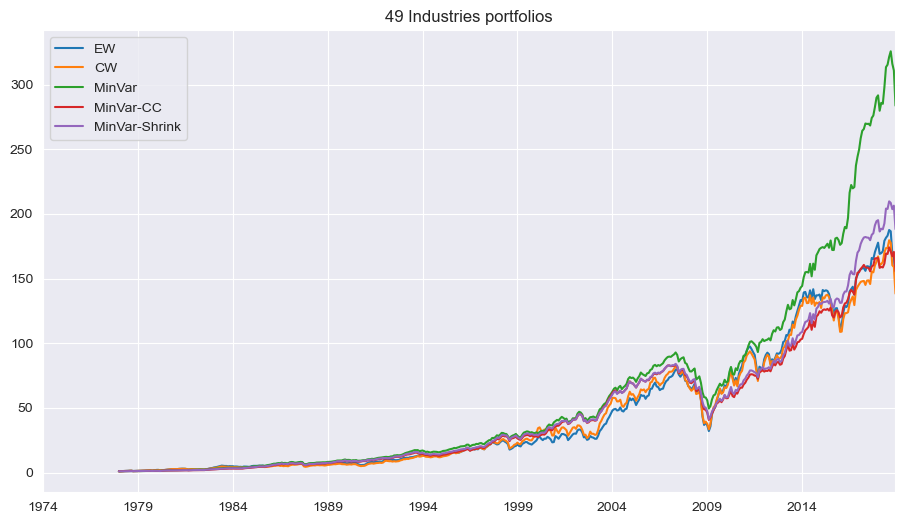

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
EW,0.129403,0.189212,0.511098,-0.609188,6.670753,0.124043,0.083067,-0.598060
CW,0.127760,0.187210,0.508023,-0.582342,5.799216,0.121187,0.082793,-0.592711
MinVar,0.147689,0.117447,0.975231,-0.715385,5.781004,0.074018,0.048249,-0.466831
MinVar-CC,0.131019,0.116062,0.847057,-0.856216,5.776079,0.076425,0.049984,-0.512959
MinVar-Shrink,0.136257,0.115169,0.897895,-0.807347,5.615668,0.074906,0.048834,-0.508177


In [13]:
# Standard covariance matrix
minvar_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.sample_cov, periods_per_year=12)

# Constant correlation covariance matrix
minvar_cc_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.cc_cov, periods_per_year=12)

# Shrinkage covariance matrix
minvar_shrink_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.shrinkage_cov, periods_per_year=12)

bt_rets = pd.DataFrame({"EW": ew_rets, "CW": cw_rets, "MinVar": minvar_rets, "MinVar-CC": minvar_cc_rets, "MinVar-Shrink": minvar_shrink_rets})
bt_growth = (1 + bt_rets).cumprod()
bt_growth.plot(grid=True, figsize=(11,6), title="{} Industries portfolios".format(nind))
plt.show()

pok.summary_stats(bt_rets.dropna())

Minimum variance portfolios are constructed using standard, constant correlation, and shrinkage covariance matrices. The performance of these portfolios is then compared.

- Analyzing Portfolio Weights

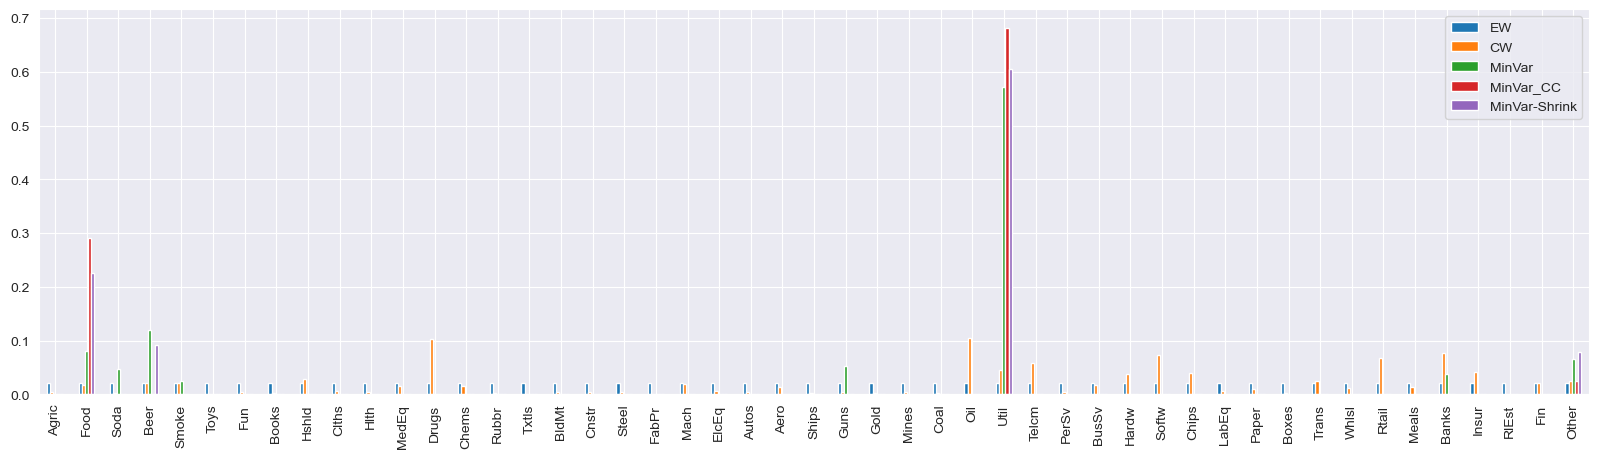

In [19]:
# # Standard covariance matrix
# minvar_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.sample_cov, periods_per_year=12)

# # Constant correlation covariance matrix
# minvar_cc_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.cc_cov, periods_per_year=12)

# # Shrinkage covariance matrix
# minvar_shrink_rets = pok.backtest_weight_scheme(ind_rets, window=window, weight_scheme=pok.weight_minvar, cov_estimator=pok.shrinkage_cov, periods_per_year=12)
ww = pd.DataFrame({    
    "EW": pok.weight_ew(ind_rets["2009":]),
    "CW": pok.weight_cw(ind_rets["2009":], cap_ws=ind_mcap),
    "MinVar": pok.weight_minvar(ind_rets["2009":], cov_estimator=pok.sample_cov),
    "MinVar_CC": pok.weight_minvar(ind_rets["2009":], cov_estimator=pok.cc_cov),
    "MinVar-Shrink": pok.weight_minvar(ind_rets["2009":], cov_estimator=pok.shrinkage_cov),
})
ww.plot.bar(grid=True, figsize=(20,5))
plt.show()

This block of code displays the weight distribution for each portfolio type, providing insights into how the different covariance estimators influence the portfolio composition.

#### Additional Analysis: VaR and ES

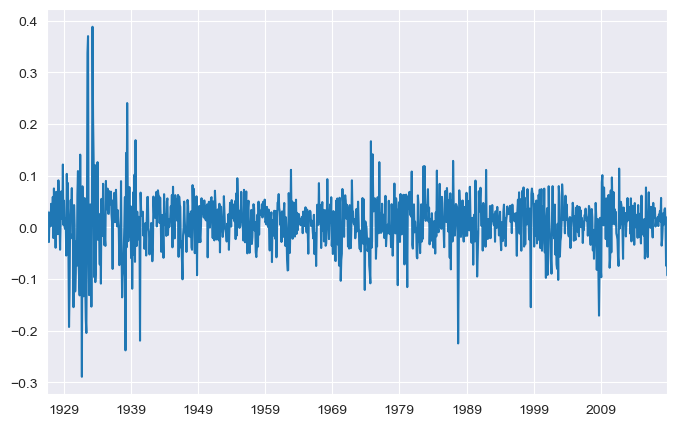

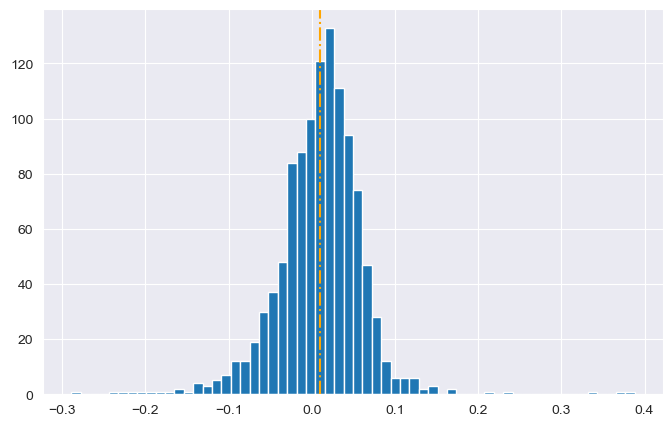

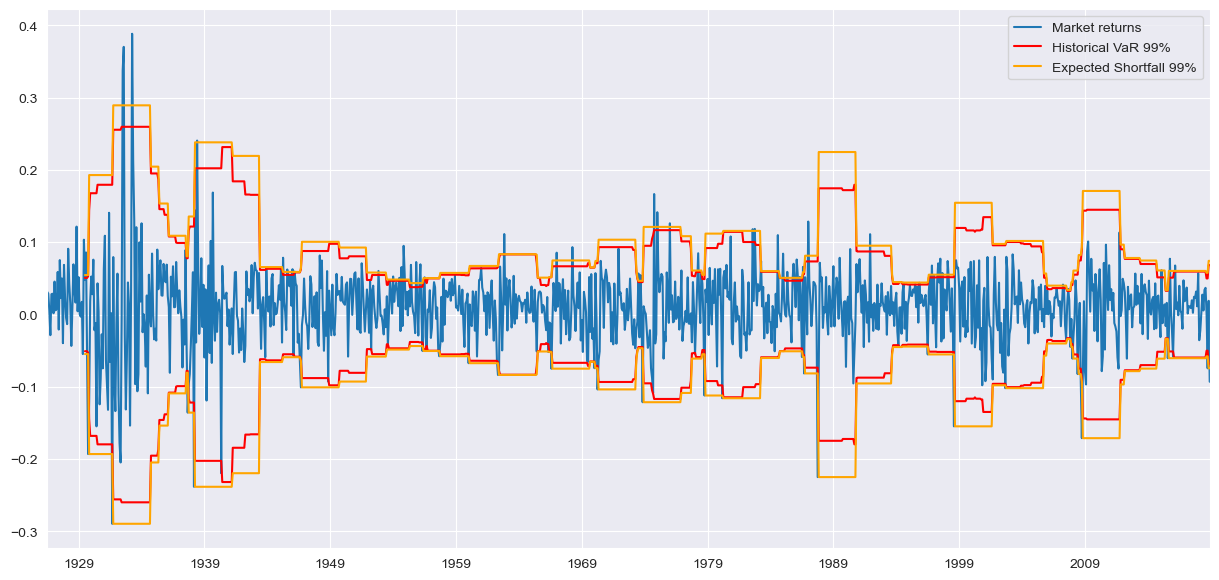

In [17]:
tot_mkt_rets = pok.get_total_market_index_returns()
tot_mkt_rets.plot(grid=True, figsize=(8,5))
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,5))
tot_mkt_rets.hist(ax=ax, bins=60)
ax.axvline(x=tot_mkt_rets.mean(), linestyle="-.", color="orange")

alpha = np.array([0.90, 0.95, 0.99])
level = 1 - alpha
VaRs = -np.percentile(tot_mkt_rets, level*100)
VaRs

alpha = 0.99
level = 1 - alpha
N = tot_mkt_rets.shape[0]
roll_window = 12*3
windows = [[start, start + roll_window] for start in range(0, N-roll_window)]
nans = np.repeat(np.nan, roll_window).tolist()
histvars = [pok.var_historic(tot_mkt_rets[w[0]:w[1]], level) for w in windows]
histvars = pd.Series(nans + histvars, index=tot_mkt_rets.index)

histES = [pok.cvar_historic(tot_mkt_rets[w[0]:w[1]], level) for w in windows]
histES = pd.Series(nans + histES, index=tot_mkt_rets.index)

fig, ax = plt.subplots(1,1,figsize=(15,7))
tot_mkt_rets.plot(ax=ax, grid=True, label="Market returns")
(+histvars).plot(ax=ax, grid=True, color="red", label="Historical VaR {:.0f}%".format(alpha*100))
(-histvars).plot(ax=ax, grid=True, color="red", label="")
(+histES).plot(ax=ax, grid=True, color="orange", label="Expected Shortfall {:.0f}%".format(alpha*100))
(-histES).plot(ax=ax, grid=True, color="orange", label="")
plt.legend()
plt.show()

This additional analysis segment plots the total market returns, calculates and visualizes historical Value at Risk (VaR) and Expected Shortfall (ES) for the market index. The ES and VaR values change over a rolling window, providing a dynamic view of market risk.